In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


2024-05-31 22:23:32.085636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 22:23:32.657297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the lrelu activation function
def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)


# Define the corrupt function (e.g., adding noise)
def corrupt(x):
    return x + 0.1 * tf.random.normal(tf.shape(x))

In [48]:
# Define the autoencoder
def autoencoder(input_shape=(28, 28, 1),
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3],
                corruption=False):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Optionally apply denoising autoencoder
    if corruption:
        x_noise = corrupt(inputs)
    else:
        x_noise = inputs

    # Calculate the dimension of x_noise
    x_dim = int(np.sqrt(input_shape[0] * input_shape[1]))

    # Reshape x_noise
    x_tensor = tf.reshape(x_noise, [-1, x_dim, x_dim, n_filters[0]])
    current_input = x_tensor

    # Build the encoder
    
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        shapes.append(current_input.shape.as_list())
        current_input = tf.keras.layers.Conv2D(
            filters=n_output, kernel_size=filter_sizes[layer_i], strides=2,
            padding='same', activation=lrelu)(current_input)
    
    # Store the latent representation
    z = current_input

    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes[::-1]):
        print("layer_i: ", layer_i, "\t shape: ", shape)
        current_input = tf.keras.layers.Conv2DTranspose(
            filters=shape[3], kernel_size=filter_sizes[layer_i], strides=2,
            padding='same', activation=lrelu)(current_input)

    # Output reconstruction
    y = tf.keras.layers.Conv2DTranspose(
                                filters=input_shape[2], kernel_size=filter_sizes[-1], strides=1,
                                padding='same', activation='sigmoid')(current_input)

    # Resize y to match the size of x_tensor
    y = tf.keras.layers.Cropping2D(((2, 2), (2, 2)))(y)
    
    print(y.shape.as_list())
    print(x_tensor.shape)

    # Cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x_tensor))

    return tf.keras.Model(inputs=inputs, outputs=y), cost

In [49]:
def test_mnist():
    # Load and preprocess the MNIST data
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = x_train.reshape((-1, 28, 28, 1))
    x_test = x_test.reshape((-1, 28, 28, 1))

    mean_img = np.mean(x_train, axis=0)

    ae, cost = autoencoder()

    learning_rate = 0.01
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Training loop
    batch_size = 100
    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(x_train.shape[0] // batch_size):
            batch_xs = x_train[batch_i * batch_size:(batch_i + 1) * batch_size]
            train = batch_xs - mean_img

            with tf.GradientTape() as tape:
                reconstruction = ae(train, training=True)
                loss = tf.reduce_sum(tf.square(reconstruction - train))

            grads = tape.gradient(loss, ae.trainable_variables)
            optimizer.apply_gradients(zip(grads, ae.trainable_variables))

        print(f"Epoch {epoch_i}, Loss: {loss.numpy()}")

    # Plot example reconstructions
    n_examples = 10
    test_xs = x_test[:n_examples]
    test_xs_norm = test_xs - mean_img
    recon = ae.predict(test_xs_norm)
    print(recon.shape)
    fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
    for example_i in range(n_examples):
        axs[0][example_i].imshow(np.reshape(test_xs[example_i, :], (28, 28)), cmap='gray')
        axs[1][example_i].imshow(np.reshape(recon[example_i, ...] + mean_img, (28, 28)), cmap='gray')
    plt.show()

layer_i:  0 	 shape:  [None, 7, 7, 10]
layer_i:  1 	 shape:  [None, 14, 14, 10]
layer_i:  2 	 shape:  [None, 28, 28, 1]
[None, 28, 28, 1]
(None, 28, 28, 1)
Epoch 0, Loss: 5069.4521484375
Epoch 1, Loss: 5069.4521484375
Epoch 2, Loss: 5069.4521484375
Epoch 3, Loss: 5069.4521484375
Epoch 4, Loss: 5069.4521484375
Epoch 5, Loss: 5069.4521484375
Epoch 6, Loss: 5069.4521484375
Epoch 7, Loss: 5069.4521484375
Epoch 8, Loss: 5069.4521484375
Epoch 9, Loss: 5069.4521484375
1/1 [==============================] - 0s 110ms/step
(10, 28, 28, 1)


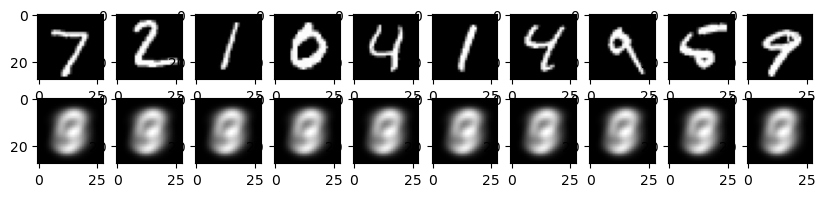

In [50]:
if __name__=='__main__':
    test_mnist()

In [ ]:
# so it isn't useful and it need some changes (maybe for future)